# Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv("corn_data.csv")
df.head()


,County,Farmer,Education,Gender,Age bracket,Household size,Crop,Acreage,Fertilizer amount,Laborers,...,Water source,Main credit source,Crop insurance,Farm records,Main advisory source,Extension provider,Advisory format,Advisory language,Latitude,Longitude
0,TAITA TAVETA,fmr_65,Certificate,Male,36-45,7,corn,2.00,50,2,...,Rain,Credit groups,No,Yes,Radio,Private Provider,Phone Calls,Vernacular,-3.46,38.35
1,TAITA TAVETA,fmr_77,Certificate,Male,36-45,7,corn,0.25,50,2,...,Rain,Credit groups,No,Yes,Radio,County Government,SMS text,Kiswahili,-3.31,38.40
2,TAITA TAVETA,fmr_89,Certificate,Male,36-45,7,corn,3.00,251,2,...,Rain,Credit groups,No,Yes,Radio,Private Provider,Phone Calls,Vernacular,-3.41,38.37
3,TAITA TAVETA,fmr_102,Certificate,Male,36-45,7,corn,1.50,300,3,...,Rain,Credit groups,No,Yes,Radio,County Government,SMS text,Kiswahili,-3.39,38.37
4,TAITA TAVETA,fmr_25,Certificate,Male,46-55,3,corn,NaN,50,2,...,Rain,Credit groups,No,Yes,Radio,Private Provider,Phone Calls,Vernacular,-3.39,38.33


In [2]:
# Data Overview
print(f"Dataset Shape: {df.shape}")
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (422, 22)

Missing Values:
County                   0
Farmer                   0
Education               26
Gender                   0
Age bracket              0
Household size           0
Crop                     0
Acreage                 71
Fertilizer amount        0
Laborers                 0
Yield                    0
Power source             0
Water source             0
Main credit source       0
Crop insurance           0
Farm records             0
Main advisory source     0
Extension provider       0
Advisory format          0
Advisory language        0
Latitude                 0
Longitude                0
dtype: int64


# Data Preprocessing

In [3]:
# Handling Missing Values
df['Acreage'].fillna(df['Acreage'].median(), inplace=True)
df.dropna(subset=['Yield'], inplace=True)

/tmp/ipython-input-3-296952513.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Acreage'].fillna(df['Acreage'].median(), inplace=True)


In [4]:
# Encode Categorical Variables
# Select categorical columns
cat_cols = ['Education', 'Gender', 'Age bracket', 'Water source', 'Main credit source', 'Advisory language']

# Apply Label Encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders for later use

In [5]:
# Select relevant features
features = [
    'Acreage', 'Fertilizer amount', 'Laborers', 'Education',
    'Gender', 'Age bracket', 'Household size', 'Water source',
    'Main credit source', 'Advisory language'
]

X = df[features]
y = df['Yield']

# Train-Test Split

In [6]:
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

In [7]:
# Define preprocessing steps
numeric_features = ['Acreage', 'Fertilizer amount', 'Laborers', 'Household size']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Education', 'Gender', 'Age bracket', 'Water source', 'Main credit source', 'Advisory language']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Acreage',
                                                   'Fertilizer amount',
                                                   'Laborers',
                                                   'Household size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Education', 'Gender',
                                                   'Age bracket',
                                                   'Water source',
                                                   'Main credit source',
                                                   'Advisory language'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Model Evaluation

In [8]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 41.35
R² Score: 0.85


# Feature Importance

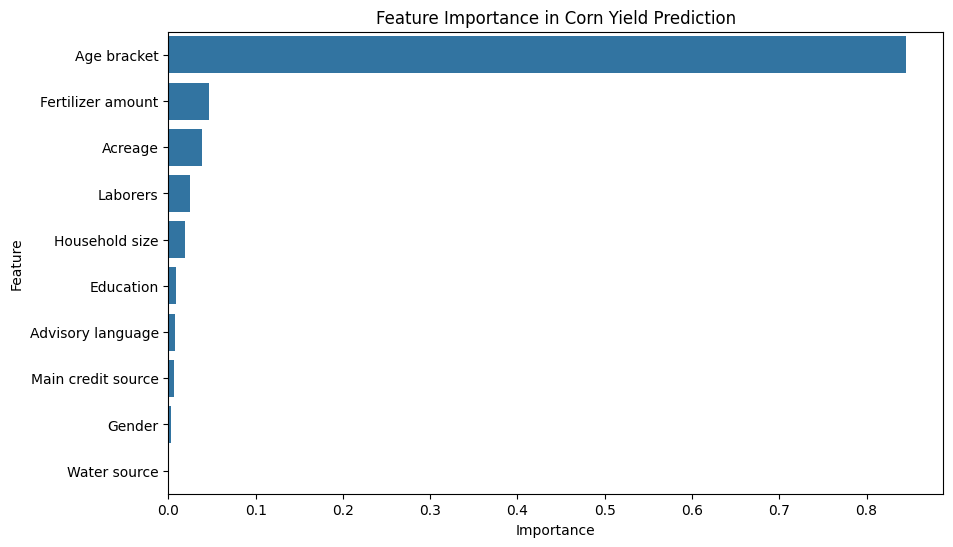

In [9]:
# Extract feature importances from the trained model
rf_model = model.named_steps['regressor']
feature_importances = pd.DataFrame({
    'Feature': numeric_features + categorical_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance in Corn Yield Prediction")
plt.show()

# Making Predictions

In [10]:
# Example: Predict yield for a new farmer
new_farmer = pd.DataFrame({
    'Acreage': [2.5],
    'Fertilizer amount': [150],
    'Laborers': [3],
    'Education': ['Primary'],
    'Gender': ['Male'],
    'Age bracket': ['36-45'],
    'Household size': [5],
    'Water source': ['Rain'],
    'Main credit source': ['Credit groups'],
    'Advisory language': ['Kiswahili']
})

# Encode categorical variables
for col in cat_cols:
    if col in new_farmer.columns:
        new_farmer[col] = label_encoders[col].transform(new_farmer[col])

# Predict yield
predicted_yield = model.predict(new_farmer)
print(f"Predicted Yield: {predicted_yield[0]:.2f} kg")

Predicted Yield: 327.60 kg


# Saving the Model for Deployment

In [11]:
import joblib

# Save the model and label encoders
joblib.dump(model, 'corn_yield_predictor.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']